In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
# Load the dataset
data = pd.read_csv('data/OnlineRetail.csv', encoding='ISO-8859-1')

print("Dataset loaded successfully!")
print(f"Dataset shape: {data.shape}")



Dataset loaded successfully!
Dataset shape: (541909, 8)


In [4]:
# View first 5 rows
print("First 5 rows of data:")
print(data.head())


First 5 rows of data:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [5]:
# Dataset information
print("\n--- Dataset Information ---")
print(data.info())



--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [6]:
# Check missing values
print("\nMissing values in each column:")
print(data.isnull().sum())



Missing values in each column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [7]:
# Remove rows with missing CustomerID (we need this for RFM)
print(f"Original dataset size: {data.shape[0]} rows")

data = data[data['CustomerID'].notna()]

print(f"After removing missing CustomerID: {data.shape[0]} rows")


Original dataset size: 541909 rows
After removing missing CustomerID: 406829 rows


In [8]:
# Remove cancelled orders (InvoiceNo starting with 'C')
data = data[~data['InvoiceNo'].astype(str).str.contains('C', na=False)]

print(f"After removing cancelled orders: {data.shape[0]} rows")


After removing cancelled orders: 397924 rows


In [9]:
# Remove negative and zero quantities and prices
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

print(f"After removing invalid quantities/prices: {data.shape[0]} rows")


After removing invalid quantities/prices: 397884 rows


In [10]:
# Create TotalPrice column (Quantity * UnitPrice)
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

print("\nNew column created: TotalPrice")
print(data[['Quantity', 'UnitPrice', 'TotalPrice']].head())



New column created: TotalPrice
   Quantity  UnitPrice  TotalPrice
0         6       2.55       15.30
1         6       3.39       20.34
2         8       2.75       22.00
3         6       3.39       20.34
4         6       3.39       20.34


In [11]:
# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

print("\nInvoiceDate converted to datetime")
print(data['InvoiceDate'].head())



InvoiceDate converted to datetime
0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


In [12]:
# Set reference date (1 day after the last transaction)
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

print(f"Reference Date for RFM calculation: {reference_date}")
print(f"Date range in data: {data['InvoiceDate'].min()} to {data['InvoiceDate'].max()}")


Reference Date for RFM calculation: 2011-12-10 12:50:00
Date range in data: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [13]:
# Calculate RFM metrics for each customer
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()

print("RFM calculation complete!")
print(f"\nTotal customers analyzed: {rfm.shape[0]}")
print("\nFirst 5 customers with RFM values:")
print(rfm.head())


RFM calculation complete!

Total customers analyzed: 4338

First 5 customers with RFM values:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


In [14]:
# View RFM statistics
print("RFM Statistics:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())


RFM Statistics:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000


In [15]:
# Assign scores from 1-5 using quantiles
# For Recency: lower is better (5 = most recent)
# For Frequency & Monetary: higher is better (5 = best)

rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=5, labels=[1,2,3,4,5])

# Convert to integer
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Calculate combined RFM Score
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

print("RFM Scores assigned!")
print("\nSample data with scores:")
print(rfm.head(10))


RFM Scores assigned!

Sample data with scores:
   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0     12346.0      326          1  77183.60        1        1        5   
1     12347.0        2          7   4310.00        5        5        5   
2     12348.0       75          4   1797.24        2        4        4   
3     12349.0       19          1   1757.55        4        1        4   
4     12350.0      310          1    334.40        1        1        2   
5     12352.0       36          8   2506.04        3        5        5   
6     12353.0      204          1     89.00        1        1        1   
7     12354.0      232          1   1079.40        1        1        4   
8     12355.0      214          1    459.40        1        1        2   
9     12356.0       23          3   2811.43        4        3        5   

   RFM_Score  
0          7  
1         15  
2         10  
3          9  
4          4  
5         13  
6          3  
7          6  
8  

In [16]:
# Create customer segments based on RFM Score
def segment_customers(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'Potential Loyalists'
    elif score >= 5:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customers)

print("Customer Segmentation Complete!")
print("\nSegment Distribution:")
print(rfm['Segment'].value_counts())


Customer Segmentation Complete!

Segment Distribution:
Segment
Potential Loyalists    1092
Loyal Customers        1008
Champions               934
At Risk                 759
Lost Customers          545
Name: count, dtype: int64


In [17]:
# Analyze each segment
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

segment_analysis.columns = ['Avg_Recency_Days', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']

print("\nSegment Analysis:")
print(segment_analysis)



Segment Analysis:
                     Avg_Recency_Days  Avg_Frequency  Avg_Monetary  \
Segment                                                              
At Risk                        147.27           1.23        342.40   
Champions                       14.61          11.74       6697.36   
Lost Customers                 254.93           1.01        192.57   
Loyal Customers                 43.42           3.86       1397.45   
Potential Loyalists             85.43           2.01        808.25   

                     Customer_Count  
Segment                              
At Risk                         759  
Champions                       934  
Lost Customers                  545  
Loyal Customers                1008  
Potential Loyalists            1092  


In [18]:
# Calculate total and percentage revenue by segment
revenue_by_segment = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
revenue_percentage = (revenue_by_segment / revenue_by_segment.sum() * 100).round(2)

print("\nTotal Revenue by Segment:")
print(revenue_by_segment)
print("\nRevenue Percentage by Segment:")
print(revenue_percentage)



Total Revenue by Segment:
Segment
Champions              6255336.530
Loyal Customers        1408629.911
Potential Loyalists     882612.662
At Risk                 259877.891
Lost Customers          104950.910
Name: Monetary, dtype: float64

Revenue Percentage by Segment:
Segment
Champions              70.19
Loyal Customers        15.81
Potential Loyalists     9.90
At Risk                 2.92
Lost Customers          1.18
Name: Monetary, dtype: float64


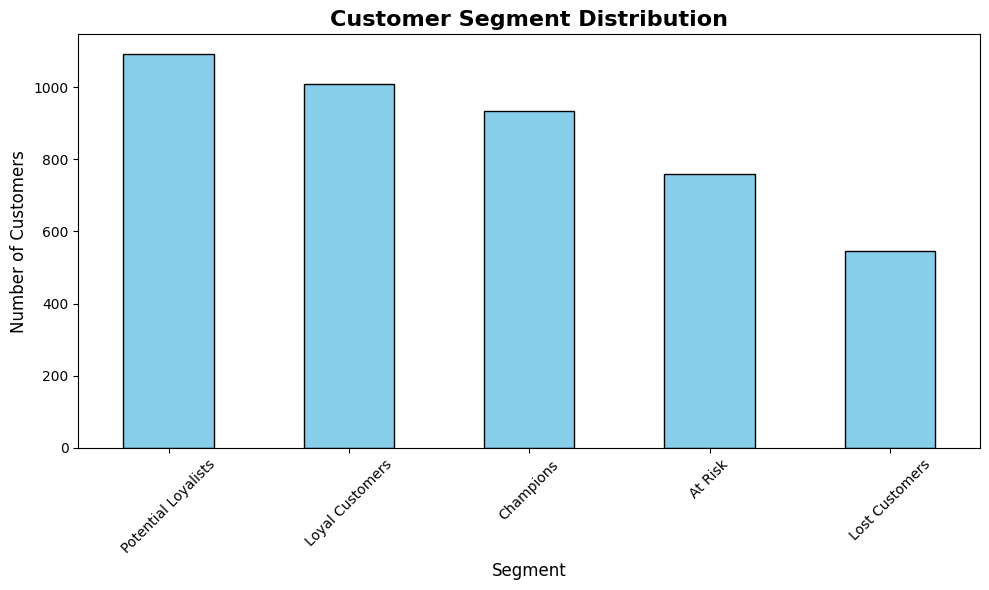

Segment distribution chart created!


In [19]:
# Create bar chart for segment distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
rfm['Segment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Customer Segment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Segment distribution chart created!")


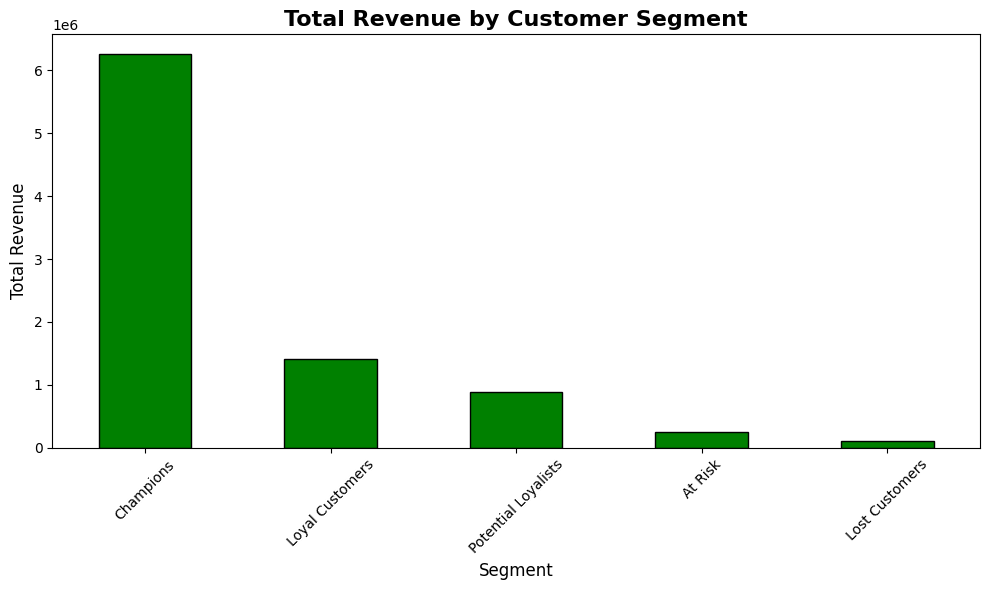

Revenue chart created!


In [20]:
# Create bar chart for revenue by segment
plt.figure(figsize=(10, 6))
revenue_by_segment.plot(kind='bar', color='green', edgecolor='black')
plt.title('Total Revenue by Customer Segment', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Revenue chart created!")


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Prepare features for clustering
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Standardize the features (important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data prepared and standardized for clustering!")
print(f"Shape of data: {X_scaled.shape}")


Data prepared and standardized for clustering!
Shape of data: (4338, 3)


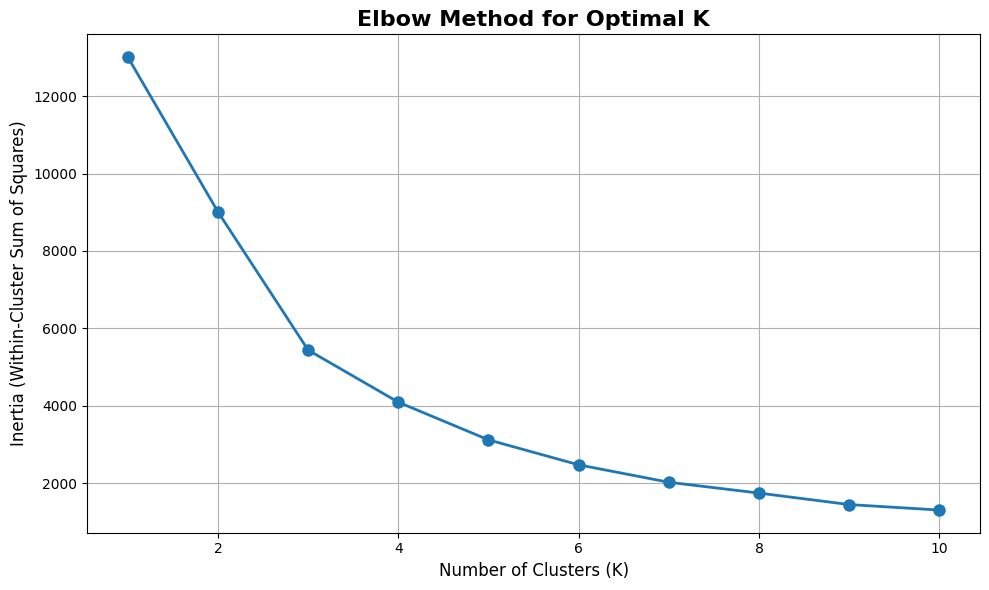

Elbow curve created! Look for the 'elbow' point (usually 4-5 clusters)


In [23]:
# Elbow method to find optimal clusters
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Elbow curve created! Look for the 'elbow' point (usually 4-5 clusters)")


In [24]:
# Apply K-Means with 4 clusters (based on elbow curve)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"K-Means clustering complete with {optimal_k} clusters!")
print("\nCluster Distribution:")
print(rfm['Cluster'].value_counts().sort_index())


K-Means clustering complete with 4 clusters!

Cluster Distribution:
Cluster
0    3054
1    1067
2      13
3     204
Name: count, dtype: int64


In [25]:
# Analyze cluster characteristics
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

cluster_analysis.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']

print("\nCluster Analysis:")
print(cluster_analysis)



Cluster Analysis:
         Avg_Recency  Avg_Frequency  Avg_Monetary  Count
Cluster                                                 
0              43.70           3.68       1359.05   3054
1             248.08           1.55        480.62   1067
2               7.38          82.54     127338.31     13
3              15.50          22.33      12709.09    204


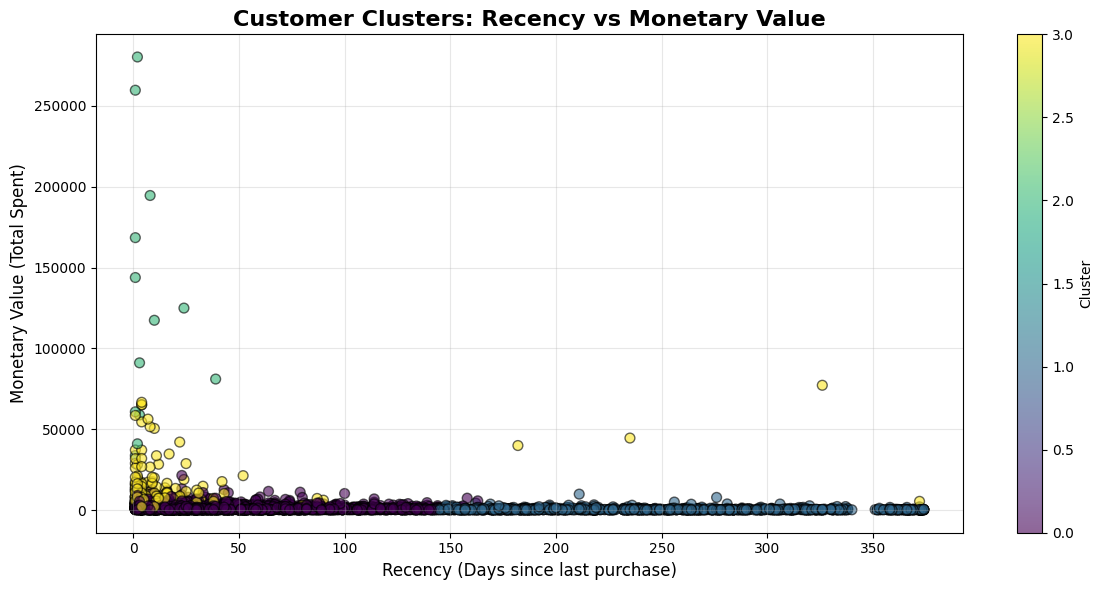

Cluster visualization created!


In [26]:
# Create scatter plot: Recency vs Monetary colored by cluster
plt.figure(figsize=(12, 6))
scatter = plt.scatter(rfm['Recency'], rfm['Monetary'], 
                      c=rfm['Cluster'], cmap='viridis', 
                      alpha=0.6, edgecolors='black', s=50)
plt.xlabel('Recency (Days since last purchase)', fontsize=12)
plt.ylabel('Monetary Value (Total Spent)', fontsize=12)
plt.title('Customer Clusters: Recency vs Monetary Value', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Cluster visualization created!")


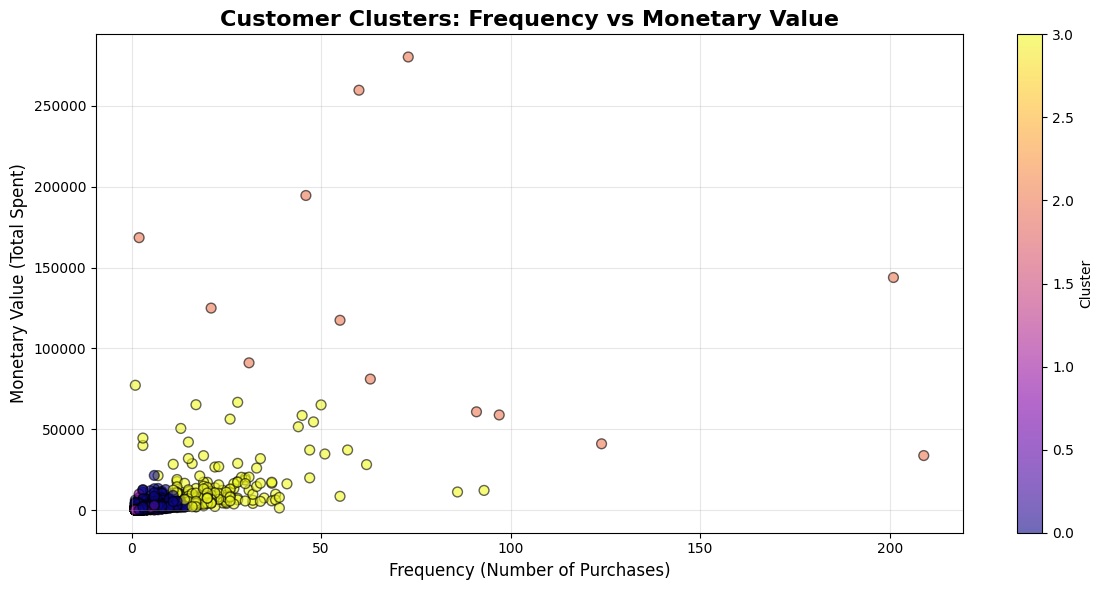

Second cluster visualization created!


In [27]:
# Create scatter plot: Frequency vs Monetary colored by cluster
plt.figure(figsize=(12, 6))
scatter = plt.scatter(rfm['Frequency'], rfm['Monetary'], 
                      c=rfm['Cluster'], cmap='plasma', 
                      alpha=0.6, edgecolors='black', s=50)
plt.xlabel('Frequency (Number of Purchases)', fontsize=12)
plt.ylabel('Monetary Value (Total Spent)', fontsize=12)
plt.title('Customer Clusters: Frequency vs Monetary Value', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Second cluster visualization created!")


In [28]:
import os
os.makedirs('visualizations', exist_ok=True)
print("✓ Visualizations folder created!")


✓ Visualizations folder created!


In [29]:
# Business recommendations for each segment
recommendations = {
    'Champions': 'Reward with VIP programs, early access to new products, exclusive offers',
    'Loyal Customers': 'Upsell premium products, request referrals and reviews',
    'Potential Loyalists': 'Offer membership programs, recommend related products',
    'At Risk': 'Send re-engagement emails, offer special discounts, win-back campaigns',
    'Lost Customers': 'Aggressive win-back campaigns with attractive offers, surveys to understand why they left'
}

print("BUSINESS RECOMMENDATIONS BY SEGMENT")
print("="*60)
for segment, recommendation in recommendations.items():
    count = rfm[rfm['Segment'] == segment].shape[0]
    revenue = rfm[rfm['Segment'] == segment]['Monetary'].sum()
    print(f"\n{segment} ({count} customers, ${revenue:,.2f} revenue):")
    print(f"  → {recommendation}")


BUSINESS RECOMMENDATIONS BY SEGMENT

Champions (934 customers, $6,255,336.53 revenue):
  → Reward with VIP programs, early access to new products, exclusive offers

Loyal Customers (1008 customers, $1,408,629.91 revenue):
  → Upsell premium products, request referrals and reviews

Potential Loyalists (1092 customers, $882,612.66 revenue):
  → Offer membership programs, recommend related products

At Risk (759 customers, $259,877.89 revenue):
  → Send re-engagement emails, offer special discounts, win-back campaigns

Lost Customers (545 customers, $104,950.91 revenue):
  → Aggressive win-back campaigns with attractive offers, surveys to understand why they left


In [30]:
# Generate key insights
total_customers = rfm.shape[0]
total_revenue = rfm['Monetary'].sum()
champions = rfm[rfm['Segment'] == 'Champions']
champions_revenue_pct = (champions['Monetary'].sum() / total_revenue * 100)

print("\nKEY INSIGHTS")
print("="*60)
print(f"1. Total Customers Analyzed: {total_customers:,}")
print(f"2. Total Revenue: ${total_revenue:,.2f}")
print(f"3. Champions represent {len(champions)/total_customers*100:.1f}% of customers")
print(f"   but contribute {champions_revenue_pct:.1f}% of total revenue")
print(f"4. Average Customer Value: ${rfm['Monetary'].mean():,.2f}")
print(f"5. Average Purchase Frequency: {rfm['Frequency'].mean():.1f} times")
print(f"6. Number of segments identified: {rfm['Segment'].nunique()} (rule-based)")
print(f"7. Number of clusters identified: {rfm['Cluster'].nunique()} (ML-based)")



KEY INSIGHTS
1. Total Customers Analyzed: 4,338
2. Total Revenue: $8,911,407.90
3. Champions represent 21.5% of customers
   but contribute 70.2% of total revenue
4. Average Customer Value: $2,054.27
5. Average Purchase Frequency: 4.3 times
6. Number of segments identified: 5 (rule-based)
7. Number of clusters identified: 4 (ML-based)


In [31]:
# Save the RFM analysis results
rfm.to_csv('data/rfm_results.csv', index=False)

print("\n✓ RFM results saved to 'data/rfm_results.csv'")
print(f"  File contains {rfm.shape[0]} customers with RFM scores, segments, and clusters")



✓ RFM results saved to 'data/rfm_results.csv'
  File contains 4338 customers with RFM scores, segments, and clusters


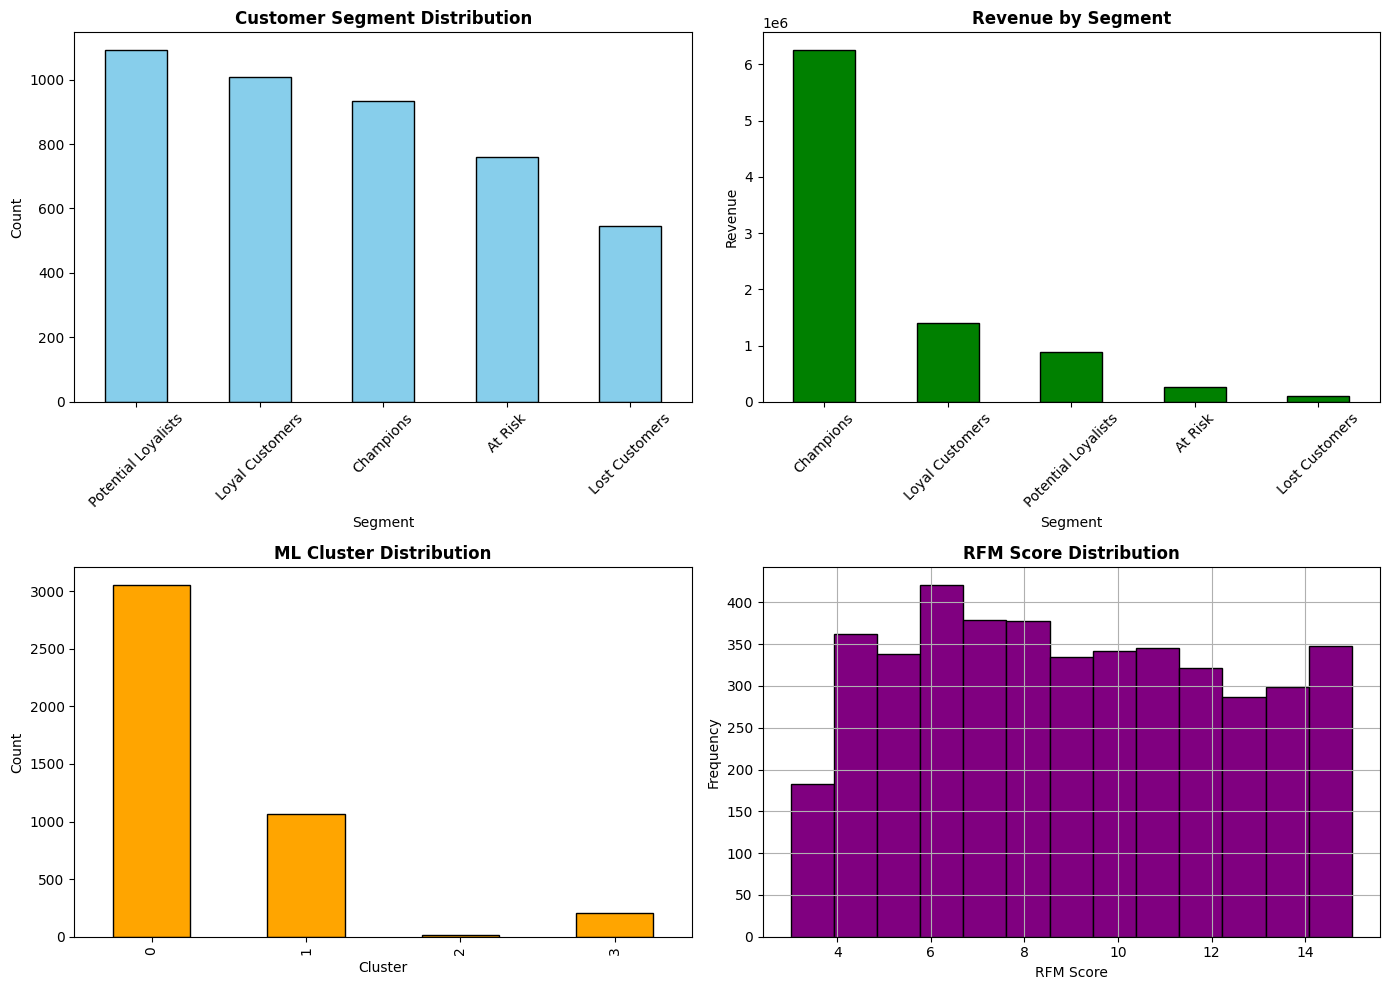


🎉 PROJECT COMPLETE! 🎉

✓ All analysis completed successfully!
✓ Summary visualization saved to 'visualizations/rfm_summary.png'
✓ RFM results saved to 'data/rfm_results.csv'

Your Customer Segmentation & RFM Analysis project is ready!
Next step: Create README.md for GitHub documentation


In [32]:
# Create comprehensive summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Segment Distribution
rfm['Segment'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue', edgecolor='black')
axes[0,0].set_title('Customer Segment Distribution', fontweight='bold')
axes[0,0].set_xlabel('Segment')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Revenue by Segment
revenue_by_segment = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
revenue_by_segment.plot(kind='bar', ax=axes[0,1], color='green', edgecolor='black')
axes[0,1].set_title('Revenue by Segment', fontweight='bold')
axes[0,1].set_xlabel('Segment')
axes[0,1].set_ylabel('Revenue')
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Cluster Distribution
rfm['Cluster'].value_counts().sort_index().plot(kind='bar', ax=axes[1,0], color='orange', edgecolor='black')
axes[1,0].set_title('ML Cluster Distribution', fontweight='bold')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Count')

# Plot 4: RFM Score Distribution
rfm['RFM_Score'].hist(bins=13, ax=axes[1,1], color='purple', edgecolor='black')
axes[1,1].set_title('RFM Score Distribution', fontweight='bold')
axes[1,1].set_xlabel('RFM Score')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('visualizations/rfm_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("🎉 PROJECT COMPLETE! 🎉")
print("="*60)
print("\n✓ All analysis completed successfully!")
print("✓ Summary visualization saved to 'visualizations/rfm_summary.png'")
print("✓ RFM results saved to 'data/rfm_results.csv'")
print("\nYour Customer Segmentation & RFM Analysis project is ready!")
print("Next step: Create README.md for GitHub documentation")


In [33]:
import sqlite3

# Create database connection
conn = sqlite3.connect('customer_segmentation.db')

# Store RFM results in database
rfm.to_sql('customer_rfm', conn, if_exists='replace', index=False)

print("✓ Database created: customer_segmentation.db")
print("✓ Table created: customer_rfm")
print(f"  {rfm.shape[0]} records stored")


✓ Database created: customer_segmentation.db
✓ Table created: customer_rfm
  4338 records stored


In [34]:
# SQL Query 1: Segment Summary
query1 = """
SELECT 
    Segment,
    COUNT(*) as Customer_Count,
    ROUND(AVG(Recency), 2) as Avg_Recency,
    ROUND(AVG(Frequency), 2) as Avg_Frequency,
    ROUND(AVG(Monetary), 2) as Avg_Monetary,
    ROUND(SUM(Monetary), 2) as Total_Revenue
FROM customer_rfm
GROUP BY Segment
ORDER BY Total_Revenue DESC
"""

print("SQL Query Result: Segment Analysis")
print("="*60)
segment_sql = pd.read_sql(query1, conn)
print(segment_sql)


SQL Query Result: Segment Analysis
               Segment  Customer_Count  Avg_Recency  Avg_Frequency  \
0            Champions             934        14.61          11.74   
1      Loyal Customers            1008        43.42           3.86   
2  Potential Loyalists            1092        85.43           2.01   
3              At Risk             759       147.27           1.23   
4       Lost Customers             545       254.93           1.01   

   Avg_Monetary  Total_Revenue  
0       6697.36     6255336.53  
1       1397.45     1408629.91  
2        808.25      882612.66  
3        342.40      259877.89  
4        192.57      104950.91  


In [35]:
# SQL Query 2: Top 10 Champions
query2 = """
SELECT CustomerID, Recency, Frequency, Monetary, RFM_Score, Segment
FROM customer_rfm
WHERE Segment = 'Champions'
ORDER BY Monetary DESC
LIMIT 10
"""

print("\n\nTop 10 Champions by Revenue:")
print("="*60)
print(pd.read_sql(query2, conn))

# SQL Query 3: At-Risk High-Value Customers
query3 = """
SELECT CustomerID, Recency, Frequency, Monetary, Segment
FROM customer_rfm
WHERE Segment = 'At Risk' AND Monetary > 1000
ORDER BY Monetary DESC
"""

print("\n\nAt-Risk Customers with High Historical Value:")
print("="*60)
print(pd.read_sql(query3, conn))

# Close connection
conn.close()
print("\n✓ SQL analysis complete!")




Top 10 Champions by Revenue:
   CustomerID  Recency  Frequency   Monetary  RFM_Score    Segment
0     14646.0        2         73  280206.02         15  Champions
1     18102.0        1         60  259657.30         15  Champions
2     17450.0        8         46  194550.79         15  Champions
3     16446.0        1          2  168472.50         13  Champions
4     14911.0        1        201  143825.06         15  Champions
5     12415.0       24         21  124914.53         14  Champions
6     14156.0       10         55  117379.63         15  Champions
7     17511.0        3         31   91062.38         15  Champions
8     16029.0       39         63   81024.84         13  Champions
9     16684.0        4         28   66653.56         15  Champions


At-Risk Customers with High Historical Value:
    CustomerID  Recency  Frequency  Monetary  Segment
0      14935.0      297          1   1784.71  At Risk
1      12764.0      317          1   1693.88  At Risk
2      12818.0      26

In [36]:
# Calculate Customer Lifetime Value (CLV)
# Formula: CLV = (Average Purchase Value × Purchase Frequency × Customer Lifespan)

# Assumptions
avg_customer_lifespan_years = 3  # Industry standard assumption
months_per_year = 12

# Calculate components
rfm['Avg_Purchase_Value'] = rfm['Monetary'] / rfm['Frequency']
rfm['Purchase_Frequency_Per_Year'] = rfm['Frequency'] * 12  # Annualized

# Calculate CLV
rfm['CLV'] = (rfm['Avg_Purchase_Value'] * rfm['Purchase_Frequency_Per_Year'] * avg_customer_lifespan_years)

print("✓ Customer Lifetime Value (CLV) calculated!")
print(f"\nCLV Statistics:")
print(rfm['CLV'].describe())
print(f"\nSample CLV data:")
print(rfm[['CustomerID', 'Segment', 'Monetary', 'Frequency', 'CLV']].head(10))


✓ Customer Lifetime Value (CLV) calculated!

CLV Statistics:
count    4.338000e+03
mean     7.395359e+04
std      3.236123e+05
min      1.350000e+02
25%      1.106694e+04
50%      2.428146e+04
75%      5.982264e+04
max      1.008742e+07
Name: CLV, dtype: float64

Sample CLV data:
   CustomerID              Segment  Monetary  Frequency         CLV
0     12346.0  Potential Loyalists  77183.60          1  2778609.60
1     12347.0            Champions   4310.00          7   155160.00
2     12348.0      Loyal Customers   1797.24          4    64700.64
3     12349.0  Potential Loyalists   1757.55          1    63271.80
4     12350.0       Lost Customers    334.40          1    12038.40
5     12352.0            Champions   2506.04          8    90217.44
6     12353.0       Lost Customers     89.00          1     3204.00
7     12354.0              At Risk   1079.40          1    38858.40
8     12355.0       Lost Customers    459.40          1    16538.40
9     12356.0      Loyal Customers   28

In [37]:
# Analyze CLV by segment
clv_by_segment = rfm.groupby('Segment').agg({
    'CLV': ['mean', 'median', 'sum', 'count']
}).round(2)

clv_by_segment.columns = ['Avg_CLV', 'Median_CLV', 'Total_CLV', 'Customer_Count']
clv_by_segment = clv_by_segment.sort_values('Total_CLV', ascending=False)

print("\nCLV Analysis by Segment:")
print("="*60)
print(clv_by_segment)

# Calculate CLV contribution percentage
clv_by_segment['CLV_Percentage'] = (clv_by_segment['Total_CLV'] / clv_by_segment['Total_CLV'].sum() * 100).round(2)
print("\nCLV Contribution by Segment (%):")
print(clv_by_segment[['Customer_Count', 'Total_CLV', 'CLV_Percentage']])



CLV Analysis by Segment:
                       Avg_CLV  Median_CLV     Total_CLV  Customer_Count
Segment                                                                 
Champions            241105.05   108338.94  2.251921e+08             934
Loyal Customers       50308.21    39431.52  5.071068e+07            1008
Potential Loyalists   29097.12    19078.38  3.177406e+07            1092
At Risk               12326.22    10941.48  9.355604e+06             759
Lost Customers         6932.54     6121.44  3.778233e+06             545

CLV Contribution by Segment (%):
                     Customer_Count     Total_CLV  CLV_Percentage
Segment                                                          
Champions                       934  2.251921e+08           70.19
Loyal Customers                1008  5.071068e+07           15.81
Potential Loyalists            1092  3.177406e+07            9.90
At Risk                         759  9.355604e+06            2.92
Lost Customers                  5

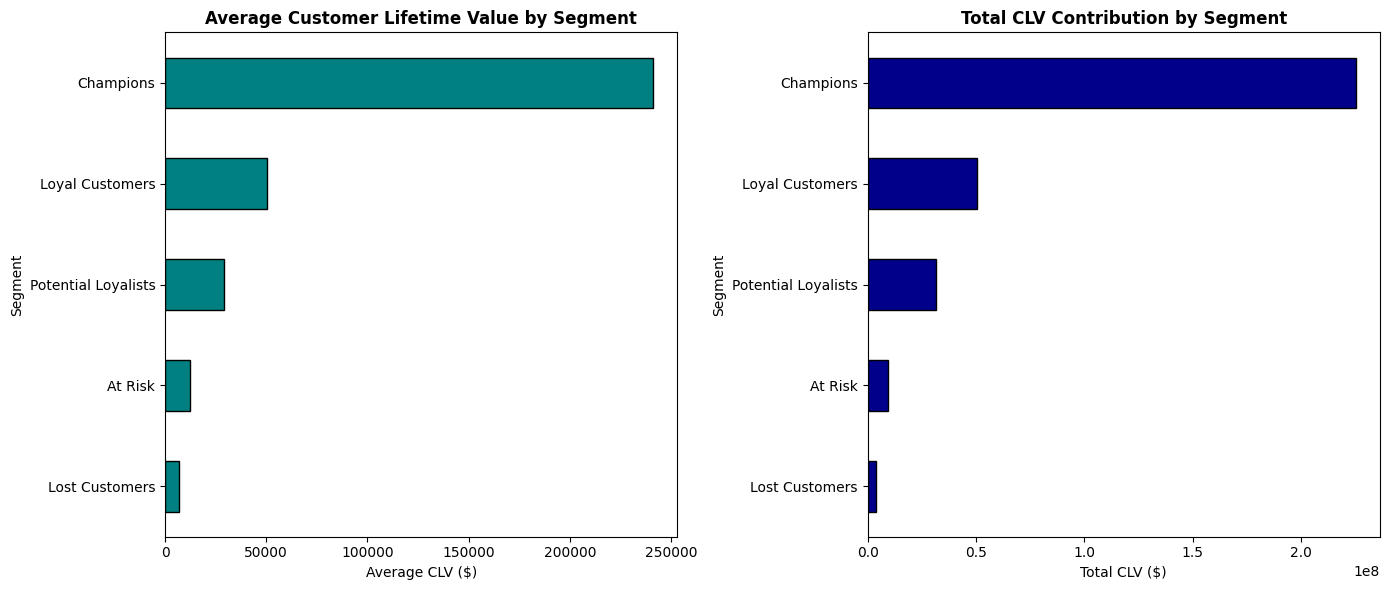

✓ CLV visualizations saved!


In [38]:
# Visualization 1: Average CLV by Segment
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Average CLV
clv_by_segment['Avg_CLV'].sort_values().plot(kind='barh', ax=axes[0], color='teal', edgecolor='black')
axes[0].set_title('Average Customer Lifetime Value by Segment', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Average CLV ($)')
axes[0].set_ylabel('Segment')

# Plot 2: Total CLV Contribution
clv_by_segment['Total_CLV'].sort_values().plot(kind='barh', ax=axes[1], color='darkblue', edgecolor='black')
axes[1].set_title('Total CLV Contribution by Segment', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Total CLV ($)')
axes[1].set_ylabel('Segment')

plt.tight_layout()
plt.savefig('visualizations/clv_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ CLV visualizations saved!")


In [39]:
# Identify top 20% high CLV customers
clv_80th_percentile = rfm['CLV'].quantile(0.80)

rfm['CLV_Category'] = rfm['CLV'].apply(lambda x: 'High Value' if x >= clv_80th_percentile else 'Standard Value')

print(f"\nHigh-Value Customer Threshold: ${clv_80th_percentile:,.2f}")
print("\nCLV Category Distribution:")
print(rfm['CLV_Category'].value_counts())

print("\nHigh-Value Customers by Segment:")
print(pd.crosstab(rfm['Segment'], rfm['CLV_Category']))



High-Value Customer Threshold: $74,103.34

CLV Category Distribution:
CLV_Category
Standard Value    3470
High Value         868
Name: count, dtype: int64

High-Value Customers by Segment:
CLV_Category         High Value  Standard Value
Segment                                        
At Risk                       0             759
Champions                   696             238
Lost Customers                0             545
Loyal Customers             150             858
Potential Loyalists          22            1070


In [40]:
# Churn Risk Scoring based on Recency
# Logic: More days since last purchase = Higher churn risk

def assign_churn_risk(recency):
    if recency > 180:  # 6+ months inactive
        return 'High Risk'
    elif recency > 90:  # 3-6 months inactive
        return 'Medium Risk'
    else:  # Active in last 3 months
        return 'Low Risk'

rfm['Churn_Risk'] = rfm['Recency'].apply(assign_churn_risk)

print("✓ Churn Risk scoring complete!")
print("\nChurn Risk Distribution:")
print(rfm['Churn_Risk'].value_counts())
print(f"\nPercentage breakdown:")
print(rfm['Churn_Risk'].value_counts(normalize=True).mul(100).round(2))


✓ Churn Risk scoring complete!

Churn Risk Distribution:
Churn_Risk
Low Risk       2889
High Risk       860
Medium Risk     589
Name: count, dtype: int64

Percentage breakdown:
Churn_Risk
Low Risk       66.60
High Risk      19.82
Medium Risk    13.58
Name: proportion, dtype: float64


In [41]:
# Analyze churn risk across segments
churn_segment_analysis = pd.crosstab(rfm['Segment'], rfm['Churn_Risk'], margins=True)

print("\nSegment vs Churn Risk Analysis:")
print("="*60)
print(churn_segment_analysis)

# Percentage breakdown
churn_percentage = pd.crosstab(rfm['Segment'], rfm['Churn_Risk'], normalize='index').mul(100).round(2)
print("\nPercentage of Churn Risk within Each Segment:")
print(churn_percentage)



Segment vs Churn Risk Analysis:
Churn_Risk           High Risk  Low Risk  Medium Risk   All
Segment                                                    
At Risk                    260       327          172   759
Champions                    0       934            0   934
Lost Customers             462        15           68   545
Loyal Customers             10       896          102  1008
Potential Loyalists        128       717          247  1092
All                        860      2889          589  4338

Percentage of Churn Risk within Each Segment:
Churn_Risk           High Risk  Low Risk  Medium Risk
Segment                                              
At Risk                  34.26     43.08        22.66
Champions                 0.00    100.00         0.00
Lost Customers           84.77      2.75        12.48
Loyal Customers           0.99     88.89        10.12
Potential Loyalists      11.72     65.66        22.62


In [42]:
# Find high-value customers at risk of churning
priority_retention = rfm[(rfm['Churn_Risk'].isin(['High Risk', 'Medium Risk'])) & 
                         (rfm['Monetary'] > rfm['Monetary'].median())]

print(f"\n⚠️ Priority Retention List: {len(priority_retention)} customers")
print("  (High/Medium churn risk + Above-average spending)")
print("\nTop 10 Priority Retention Customers:")
print(priority_retention.nlargest(10, 'Monetary')[['CustomerID', 'Segment', 'Recency', 'Monetary', 'Churn_Risk']])

# Calculate potential revenue at risk
revenue_at_risk = priority_retention['Monetary'].sum()
print(f"\n💰 Total Historical Revenue at Risk: ${revenue_at_risk:,.2f}")



⚠️ Priority Retention List: 366 customers
  (High/Medium churn risk + Above-average spending)

Top 10 Priority Retention Customers:
      CustomerID              Segment  Recency  Monetary   Churn_Risk
0        12346.0  Potential Loyalists      326  77183.60    High Risk
2502     15749.0  Potential Loyalists      235  44534.30    High Risk
2011     15098.0  Potential Loyalists      182  39916.50    High Risk
2814     16180.0      Loyal Customers      100  10254.18  Medium Risk
196      12590.0  Potential Loyalists      211   9864.26    High Risk
566      13093.0      Loyal Customers      276   7832.47    High Risk
485      12980.0      Loyal Customers      158   7374.90  Medium Risk
519      13027.0      Loyal Customers      114   6912.00  Medium Risk
3083     16553.0      Loyal Customers      163   5719.82  Medium Risk
4016     17850.0      Loyal Customers      372   5391.21    High Risk

💰 Total Historical Revenue at Risk: $717,531.45


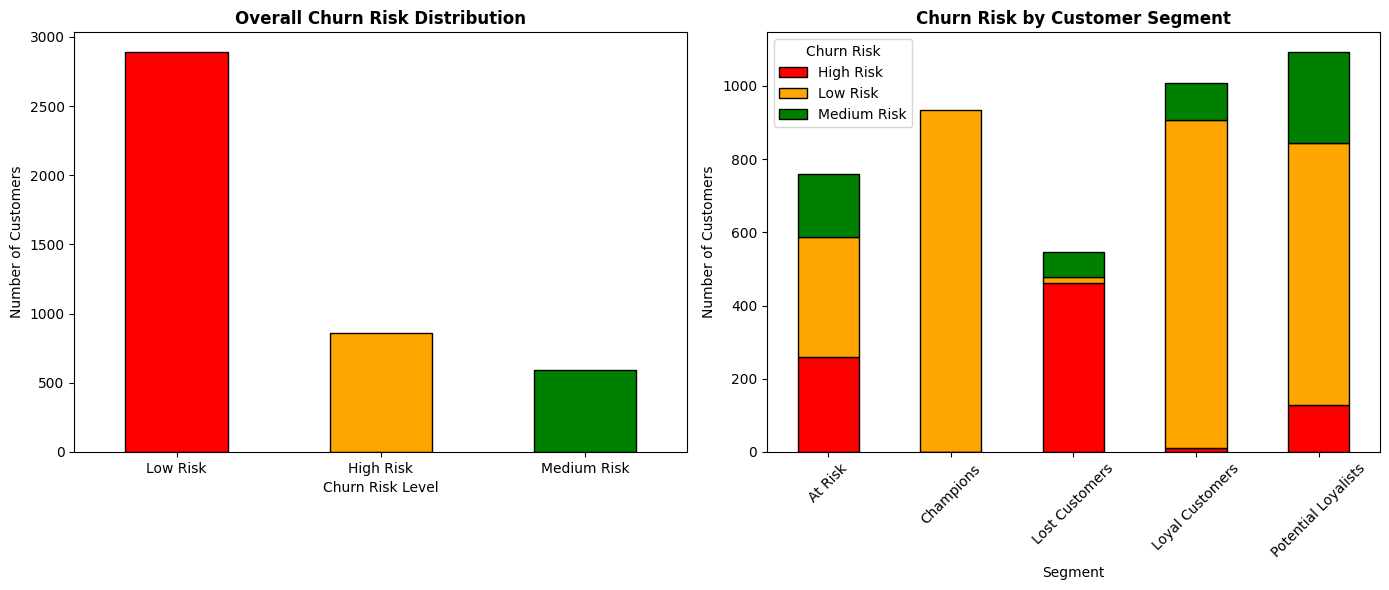

✓ Churn risk visualizations saved!


In [43]:
# Visualization: Churn Risk Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Overall Churn Risk Distribution
rfm['Churn_Risk'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'orange', 'green'], edgecolor='black')
axes[0].set_title('Overall Churn Risk Distribution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Churn Risk Level')
axes[0].set_ylabel('Number of Customers')
axes[0].tick_params(axis='x', rotation=0)

# Plot 2: Churn Risk by Segment (Stacked)
churn_segment_counts = pd.crosstab(rfm['Segment'], rfm['Churn_Risk'])
churn_segment_counts.plot(kind='bar', stacked=True, ax=axes[1], 
                          color=['red', 'orange', 'green'], edgecolor='black')
axes[1].set_title('Churn Risk by Customer Segment', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Segment')
axes[1].set_ylabel('Number of Customers')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Churn Risk')

plt.tight_layout()
plt.savefig('visualizations/churn_risk_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Churn risk visualizations saved!")


In [44]:
# Cohort Analysis: Group customers by their first purchase month
# Get first purchase date for each customer
cohort_data = data.groupby('CustomerID')['InvoiceDate'].min().reset_index()
cohort_data.columns = ['CustomerID', 'First_Purchase_Date']

# Extract cohort month (year-month)
cohort_data['Cohort_Month'] = cohort_data['First_Purchase_Date'].dt.to_period('M')

# Merge with RFM data
rfm_cohort = rfm.merge(cohort_data[['CustomerID', 'Cohort_Month']], on='CustomerID', how='left')

print("✓ Cohort analysis data prepared!")
print(f"\nNumber of cohorts identified: {rfm_cohort['Cohort_Month'].nunique()}")
print("\nFirst 5 cohorts:")
print(rfm_cohort['Cohort_Month'].value_counts().sort_index().head())


✓ Cohort analysis data prepared!

Number of cohorts identified: 13

First 5 cohorts:
Cohort_Month
2010-12    885
2011-01    417
2011-02    380
2011-03    452
2011-04    300
Freq: M, Name: count, dtype: int64


In [45]:
# Analyze cohorts by key metrics
cohort_analysis = rfm_cohort.groupby('Cohort_Month').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum'],
    'CLV': 'mean'
}).round(2)

cohort_analysis.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 
                           'Avg_Monetary', 'Total_Revenue', 'Avg_CLV']

print("\nCohort Analysis Summary:")
print("="*60)
print(cohort_analysis.head(10))

# Find best performing cohort
best_cohort = cohort_analysis['Total_Revenue'].idxmax()
print(f"\n🏆 Best Performing Cohort: {best_cohort}")
print(f"   Total Revenue: ${cohort_analysis.loc[best_cohort, 'Total_Revenue']:,.2f}")



Cohort Analysis Summary:
              Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
Cohort_Month                                                             
2010-12                  885        97.86           9.40       5098.47   
2011-01                  417       117.76           5.16       2699.96   
2011-02                  380       126.69           4.11       1562.83   
2011-03                  452       127.73           3.56       1424.25   
2011-04                  300       126.80           3.08       1088.74   
2011-05                  284       108.43           2.88       1604.03   
2011-06                  242        94.61           2.73       1129.98   
2011-07                  188        88.36           2.35        768.45   
2011-08                  169        74.09           2.12       1160.05   
2011-09                  299        55.51           1.99        780.26   

              Total_Revenue    Avg_CLV  
Cohort_Month                            
201

In [46]:
# Analyze cohort retention (customers still active vs churned)
cohort_retention = rfm_cohort.groupby('Cohort_Month').agg({
    'CustomerID': 'count',
    'Churn_Risk': lambda x: (x == 'Low Risk').sum()
}).round(2)

cohort_retention.columns = ['Total_Customers', 'Active_Customers']
cohort_retention['Retention_Rate'] = (cohort_retention['Active_Customers'] / 
                                      cohort_retention['Total_Customers'] * 100).round(2)

print("\nCohort Retention Analysis:")
print("="*60)
print(cohort_retention.head(10))

print(f"\nOverall Average Retention Rate: {cohort_retention['Retention_Rate'].mean():.2f}%")



Cohort Retention Analysis:
              Total_Customers  Active_Customers  Retention_Rate
Cohort_Month                                                   
2010-12                   885               612           69.15
2011-01                   417               256           61.39
2011-02                   380               204           53.68
2011-03                   452               236           52.21
2011-04                   300               137           45.67
2011-05                   284               147           51.76
2011-06                   242               129           53.31
2011-07                   188                87           46.28
2011-08                   169                83           49.11
2011-09                   299               276           92.31

Overall Average Retention Rate: 67.30%


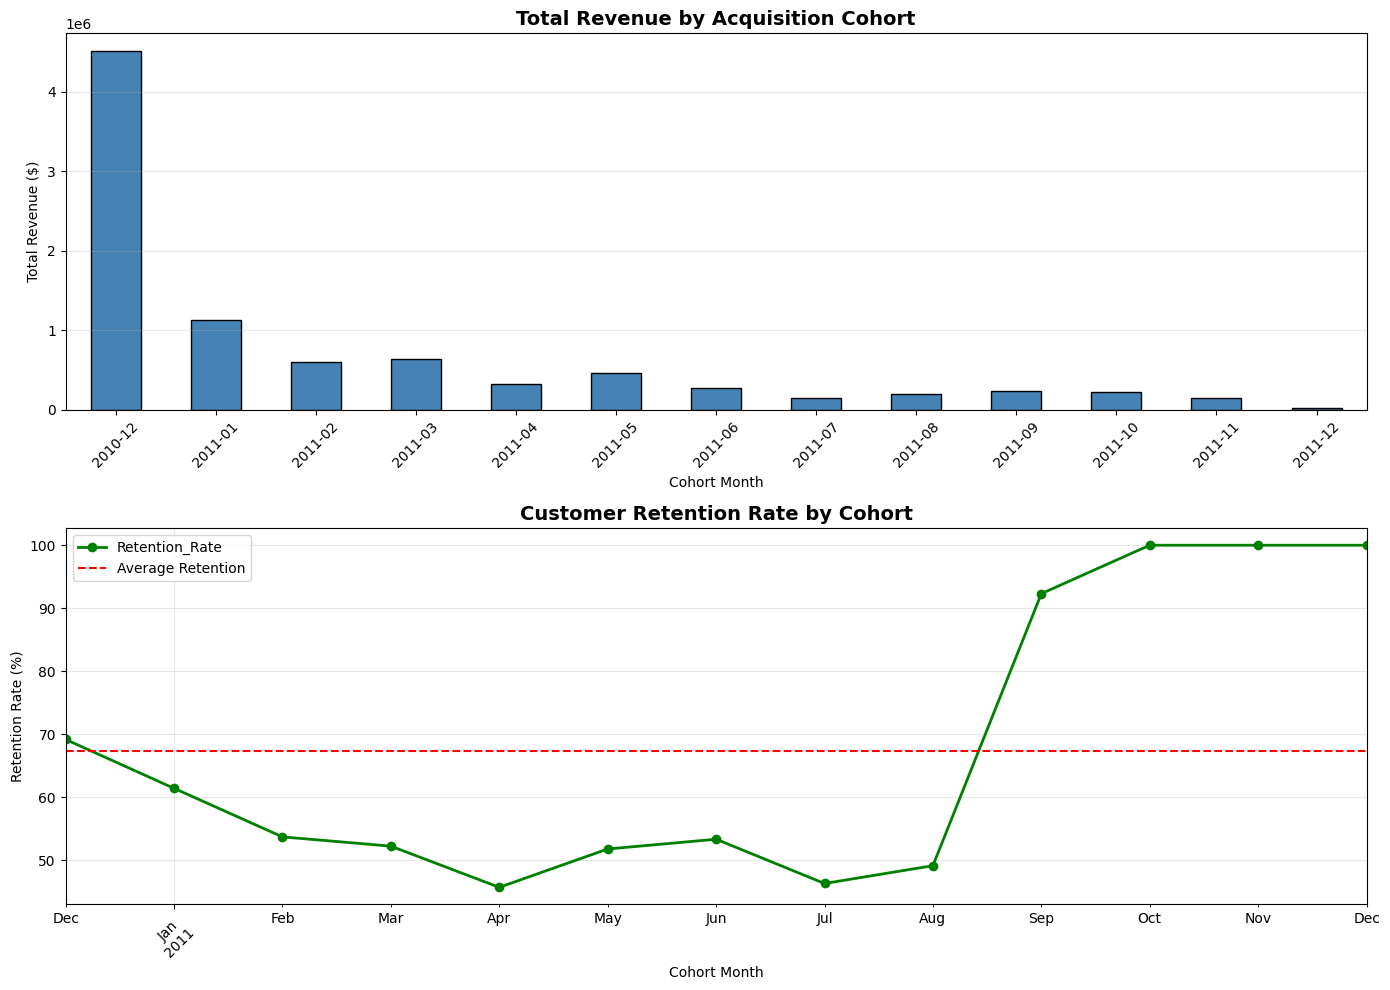

✓ Cohort analysis visualizations saved!


In [47]:
# Visualization: Cohort Performance
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Total Revenue by Cohort
cohort_analysis['Total_Revenue'].plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Total Revenue by Acquisition Cohort', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Cohort Month')
axes[0].set_ylabel('Total Revenue ($)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Retention Rate by Cohort
cohort_retention['Retention_Rate'].plot(kind='line', ax=axes[1], color='green', 
                                        marker='o', linewidth=2, markersize=6)
axes[1].set_title('Customer Retention Rate by Cohort', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Cohort Month')
axes[1].set_ylabel('Retention Rate (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=cohort_retention['Retention_Rate'].mean(), color='red', 
                linestyle='--', label='Average Retention')
axes[1].legend()

plt.tight_layout()
plt.savefig('visualizations/cohort_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Cohort analysis visualizations saved!")


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create target variable: Will customer purchase again? (Based on Recency)
# Logic: If Recency < 90 days, likely to purchase again (1), else unlikely (0)
rfm['Will_Purchase_Again'] = (rfm['Recency'] < 90).astype(int)

print("✓ Target variable created: Will_Purchase_Again")
print("\nTarget Distribution:")
print(rfm['Will_Purchase_Again'].value_counts())
print(f"\nPercentage likely to purchase again: {rfm['Will_Purchase_Again'].mean()*100:.2f}%")


✓ Target variable created: Will_Purchase_Again

Target Distribution:
Will_Purchase_Again
1    2880
0    1458
Name: count, dtype: int64

Percentage likely to purchase again: 66.39%


In [49]:
# Prepare features and target
features = ['Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']
X = rfm[features]
y = rfm['Will_Purchase_Again']

# Split data into train and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

print("✓ Random Forest model trained!")
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


✓ Random Forest model trained!

Training set size: 3470
Test set size: 868


In [50]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)

print("MODEL PERFORMANCE")
print("="*60)
print(f"\nAccuracy: {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Will Not Purchase', 'Will Purchase']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


MODEL PERFORMANCE

Accuracy: 93.55%

Classification Report:
                   precision    recall  f1-score   support

Will Not Purchase       0.86      0.97      0.91       308
    Will Purchase       0.98      0.91      0.95       560

         accuracy                           0.94       868
        macro avg       0.92      0.94      0.93       868
     weighted avg       0.94      0.94      0.94       868


Confusion Matrix:
[[300   8]
 [ 48 512]]

Feature Importance:
     Feature  Importance
2    R_Score    0.588005
5  RFM_Score    0.212875
1   Monetary    0.089855
0  Frequency    0.053599
3    F_Score    0.042671
4    M_Score    0.012994


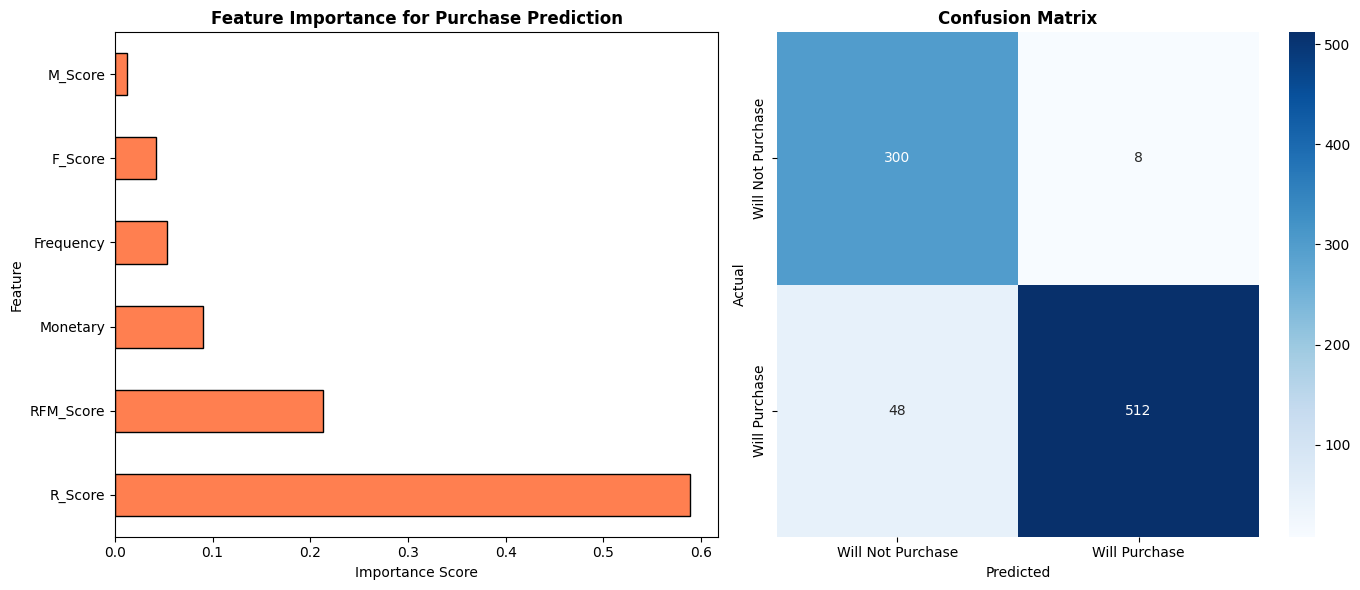

✓ Model evaluation visualizations saved!


In [51]:
# Visualization 1: Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Feature Importance
feature_importance.plot(kind='barh', x='Feature', y='Importance', ax=axes[0], 
                        color='coral', edgecolor='black', legend=False)
axes[0].set_title('Feature Importance for Purchase Prediction', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('Feature')

# Plot 2: Confusion Matrix Heatmap
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=['Will Not Purchase', 'Will Purchase'],
            yticklabels=['Will Not Purchase', 'Will Purchase'])
axes[1].set_title('Confusion Matrix', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('visualizations/predictive_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model evaluation visualizations saved!")


In [52]:
# Apply model to full dataset
rfm['Purchase_Probability'] = rf_model.predict_proba(rfm[features])[:, 1]
rfm['Predicted_Purchase'] = rf_model.predict(rfm[features])

# Segment predictions by customer segment
prediction_summary = rfm.groupby('Segment').agg({
    'Purchase_Probability': 'mean',
    'Predicted_Purchase': 'sum',
    'CustomerID': 'count'
}).round(3)

prediction_summary.columns = ['Avg_Purchase_Probability', 'Predicted_to_Purchase', 'Total_Customers']
prediction_summary['Purchase_Rate_%'] = (prediction_summary['Predicted_to_Purchase'] / 
                                          prediction_summary['Total_Customers'] * 100).round(2)

print("\nPurchase Predictions by Segment:")
print("="*60)
print(prediction_summary)

# Save predictions
rfm.to_csv('data/rfm_with_predictions.csv', index=False)
print("\n✓ Predictions saved to 'data/rfm_with_predictions.csv'")



Purchase Predictions by Segment:
                     Avg_Purchase_Probability  Predicted_to_Purchase  \
Segment                                                                
At Risk                                 0.424                    275   
Champions                               1.000                    934   
Lost Customers                          0.025                      4   
Loyal Customers                         0.884                    861   
Potential Loyalists                     0.656                    655   

                     Total_Customers  Purchase_Rate_%  
Segment                                                
At Risk                          759            36.23  
Champions                        934           100.00  
Lost Customers                   545             0.73  
Loyal Customers                 1008            85.42  
Potential Loyalists             1092            59.98  

✓ Predictions saved to 'data/rfm_with_predictions.csv'


In [53]:
# Identify actionable insights
high_prob_at_risk = rfm[(rfm['Purchase_Probability'] > 0.7) & 
                        (rfm['Segment'] == 'At Risk')]

low_prob_champions = rfm[(rfm['Purchase_Probability'] < 0.3) & 
                         (rfm['Segment'] == 'Champions')]

print("\nACTIONABLE INSIGHTS FROM PREDICTIVE MODEL")
print("="*60)

print(f"\n1. ✅ At Risk customers likely to return: {len(high_prob_at_risk)}")
print(f"   → Action: Immediate re-engagement campaigns for these {len(high_prob_at_risk)} customers")
print(f"   → Potential revenue: ${high_prob_at_risk['Monetary'].sum():,.2f}")

print(f"\n2. ⚠️ Champions unlikely to purchase soon: {len(low_prob_champions)}")
print(f"   → Action: Proactive retention offers for these {len(low_prob_champions)} high-value customers")
print(f"   → Revenue at risk: ${low_prob_champions['Monetary'].sum():,.2f}")

print(f"\n3. 📊 Overall predicted purchase rate: {rfm['Predicted_Purchase'].mean()*100:.2f}%")

print("\n✓ Predictive modeling complete!")



ACTIONABLE INSIGHTS FROM PREDICTIVE MODEL

1. ✅ At Risk customers likely to return: 251
   → Action: Immediate re-engagement campaigns for these 251 customers
   → Potential revenue: $55,270.04

2. ⚠️ Champions unlikely to purchase soon: 0
   → Action: Proactive retention offers for these 0 high-value customers
   → Revenue at risk: $0.00

3. 📊 Overall predicted purchase rate: 62.91%

✓ Predictive modeling complete!


In [56]:
# Project summary
print("Project Analysis Complete\n")

print("Dataset Overview:")
print(f"Customers analyzed: {rfm.shape[0]}")
print(f"Total revenue: ${rfm['Monetary'].sum():,.2f}\n")

print("Segments created:")
print(rfm['Segment'].value_counts())

print("\nModel performance:")
print(f"Prediction accuracy: {accuracy:.2f}")

print("\nFiles saved:")
print("- rfm_results.csv")
print("- rfm_with_predictions.csv")
print("- customer_segmentation.db")


Project Analysis Complete

Dataset Overview:
Customers analyzed: 4338
Total revenue: $8,911,407.90

Segments created:
Segment
Potential Loyalists    1092
Loyal Customers        1008
Champions               934
At Risk                 759
Lost Customers          545
Name: count, dtype: int64

Model performance:
Prediction accuracy: 0.94

Files saved:
- rfm_results.csv
- rfm_with_predictions.csv
- customer_segmentation.db
